In [1]:
# start SparkSession
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("preprocessing").getOrCreate()
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-pastel')

In [2]:
import numpy as np
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.sql.types import DoubleType
from pyspark.sql.types import StringType
import re
from pyspark.sql.functions import split
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import StopWordsRemover
import pyspark.sql.functions as f
from pyspark.ml.feature import Word2Vec
import datetime
from pyspark.sql.functions import year, month, dayofmonth, dayofweek

# 1. STORIES

In [3]:
# read in the dataset stories
data_df = spark.read\
  .format('csv')\
  .option('header', 'true')\
  .option('inferSchema', 'true')\
  .load('s3://bigdataproject233/stories.csv')

In [4]:
data_df.show()

+-------+------------+-----+------------+--------------------+--------------------+--------------------+--------------------+-------+----+-----------+------------+
|     id|          by|score|        time|             time_ts|               title|                 url|                text|deleted|dead|descendants|      author|
+-------+------------+-----+------------+--------------------+--------------------+--------------------+--------------------+-------+----+-----------+------------+
|6940813|   sarath237|  0.0|1387536270.0|2013-12-20 10:44:...| Sheryl Brindo Ho...|http://www.youtub...| Sheryl Brindo Ho...|   null|True|       null|   sarath237|
|6991401|123123321321|  0.0|1388508751.0|2013-12-31 16:52:...|Are you people al...|                null|They&#x27;re pret...|   null|True|       null|123123321321|
|1531556|         ssn|  0.0|1279617234.0|2010-07-20 09:13:...|New UI for Google...|http://googlesyst...|Again following o...|   null|null|        0.0|         ssn|
|5012398|       

In [5]:
data_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- by: string (nullable = true)
 |-- score: string (nullable = true)
 |-- time: string (nullable = true)
 |-- time_ts: string (nullable = true)
 |-- title: string (nullable = true)
 |-- url: string (nullable = true)
 |-- text: string (nullable = true)
 |-- deleted: string (nullable = true)
 |-- dead: string (nullable = true)
 |-- descendants: string (nullable = true)
 |-- author: string (nullable = true)



In [6]:
data_df.count()

2069464

In [7]:
#Set data type
story_df = data_df.select(data_df['id'].cast(IntegerType()),
                     data_df['score'].cast(IntegerType()),
                     data_df['time_ts'].cast('timestamp'),
                     data_df['title'],
                     data_df['url'],
                     data_df['text'],
                     data_df['deleted'],
                     data_df['dead'],
                     data_df['descendants'].cast(IntegerType()),
                     data_df['author']
                             )


In [8]:
story_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- score: integer (nullable = true)
 |-- time_ts: timestamp (nullable = true)
 |-- title: string (nullable = true)
 |-- url: string (nullable = true)
 |-- text: string (nullable = true)
 |-- deleted: string (nullable = true)
 |-- dead: string (nullable = true)
 |-- descendants: integer (nullable = true)
 |-- author: string (nullable = true)



In [9]:
story_df.show(10)

+-------+-----+-------------------+--------------------+--------------------+--------------------+-------+----+-----------+------------+
|     id|score|            time_ts|               title|                 url|                text|deleted|dead|descendants|      author|
+-------+-----+-------------------+--------------------+--------------------+--------------------+-------+----+-----------+------------+
|6940813|    0|2013-12-20 10:44:30| Sheryl Brindo Ho...|http://www.youtub...| Sheryl Brindo Ho...|   null|True|       null|   sarath237|
|6991401|    0|2013-12-31 16:52:31|Are you people al...|                null|They&#x27;re pret...|   null|True|       null|123123321321|
|1531556|    0|2010-07-20 09:13:54|New UI for Google...|http://googlesyst...|Again following o...|   null|null|          0|         ssn|
|5012398|    0|2013-01-05 12:11:17|Historic website ...|http://webscrapin...|Python script to ...|   null|null|          0|        hoju|
|7214182|    0|2014-05-31 18:42:20|      

In [10]:
# create temp table
story_df.createOrReplaceTempView('ini_story')

In [11]:
story_df.select("id").distinct().count()

1959840

In [12]:
story_df.select("title").distinct().count()

1759584

In [12]:
story_df.select("author").distinct().count()

208438

In [13]:
# filter the dataset in order to get clean data
sqlStatement = """
SELECT * 
FROM ini_story
WHERE id is not NULL 
and score is not NULL 
and time_ts is not NULL 
and title is not NULL 
and url is not NULL
and descendants is not NULL
and author is not NULL 
"""


In [14]:
clean_story_df = spark.sql(sqlStatement)
clean_story_df.count()
clean_story_df.createOrReplaceTempView('story1')

In [15]:
# get hostname of url as web

sqlStatement = """
SELECT id, score, time_ts,title,text,descendants,author,
regexp_extract(url, '([a-z]+).(com|net|co|cn|org|ru|de|br|uk|pl|ir|it|in|fr|au|jp|info|to|ca)', 1) as web
FROM story1 
"""

clean_story_df2 = spark.sql(sqlStatement)
clean_story_df2.createOrReplaceTempView('story')

In [16]:
clean_story_df2.select('score').describe().show()

+-------+------------------+
|summary|             score|
+-------+------------------+
|  count|           1621236|
|   mean|11.055065394550825|
| stddev|42.411855877052226|
|    min|                 0|
|    max|              4339|
+-------+------------------+



In [17]:
# website information
# Where are the stories coming from? or what are the most popular sources?

sqlStatement = """
SELECT COUNT(id) AS num, web
FROM story
WHERE web != '' and web !='www'
GROUP BY web
ORDER BY num DESC
LIMIT 20
"""
web_df1 = spark.sql(sqlStatement)

In [18]:
# show top 10
web_df1.show(10)

+-----+-----------+
|  num|        web|
+-----+-----------+
|35467|     github|
|30490| techcrunch|
|27039|    nytimes|
|25275|   blogspot|
|24271|    youtube|
|17849|     medium|
|16503|     google|
|14321|        bbc|
|13645|arstechnica|
|13375|      wired|
+-----+-----------+
only showing top 10 rows



/home/hadoop/miniconda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


Text(0, 0.5, 'Number')

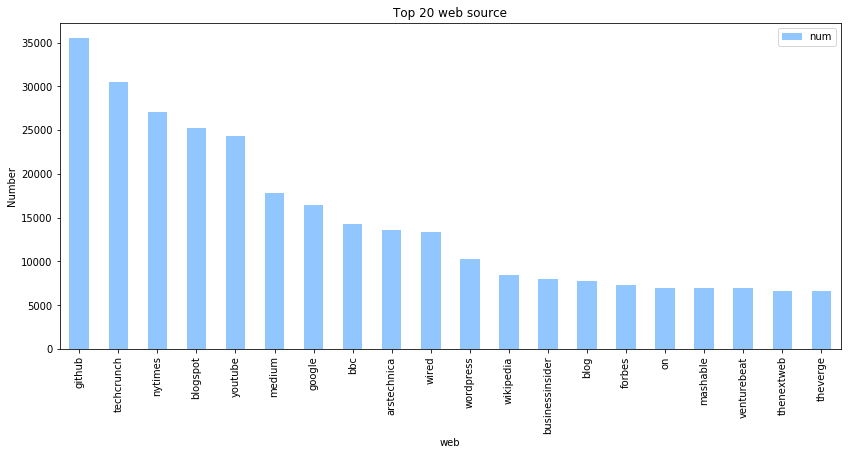

In [23]:
web_df1 = web_df1.toPandas()
web_df1.plot(x='web', y='num', 
                    kind="bar",figsize=(14,6),
                    title='Top 20 web source').set_ylabel("Number")

In [27]:
# website total score information 
# Where are the stories coming from? or what are the most popular sources?

sqlStatement = """
SELECT SUM(score) as total_score,COUNT(id) AS num, web
FROM story
WHERE web != '' and web !='www'
GROUP BY web
ORDER BY total_score DESC
LIMIT 20
"""
web_df3 = spark.sql(sqlStatement)

In [28]:
# show top 10
web_df3.show(10)

+-----------+-----+--------------+
|total_score|  num|           web|
+-----------+-----+--------------+
|     585208|35467|        github|
|     410940|30490|    techcrunch|
|     410843|27039|       nytimes|
|     299193|16503|        google|
|     269517|25275|      blogspot|
|     198873|13645|   arstechnica|
|     195978|13375|         wired|
|     179999|14321|           bbc|
|     171442|17849|        medium|
|     120304| 5914|washingtonpost|
+-----------+-----+--------------+
only showing top 10 rows



Text(0, 0.5, 'Score')

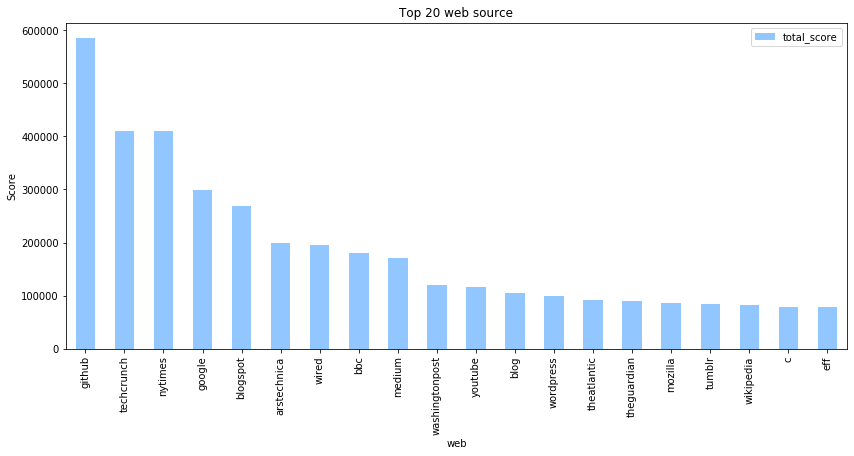

In [29]:
web_df3 = web_df3.toPandas()
web_df3.plot(x='web', y='total_score', 
                    kind="bar",figsize=(14,6),
                    title='Top 20 web source').set_ylabel("Score")

In [96]:
# website avgerage score information
# From which website the story will have a high score in total?
sqlStatement = """
SELECT AVG(score) as avg_score, web
FROM story
WHERE web != '' and web !='www'
GROUP BY web
ORDER BY avg_score DESC
LIMIT 20
"""
web_df2 = spark.sql(sqlStatement)


In [97]:
# show top 10
web_df2.show(10)

+---------+--------------------+
|avg_score|                 web|
+---------+--------------------+
|   1768.0|          heartbleed|
|   1445.0|           bekkelund|
|   1323.0|          spritelamp|
|   1215.0|spotthedrowningchild|
|   1167.0|    standardmarkdown|
|   1086.0|            jeffepst|
|   1055.0|       projectnaptha|
|    925.0|     gabrielecirulli|
|    910.0|    gameaboutsquares|
|    868.0|                kfor|
+---------+--------------------+
only showing top 10 rows



Text(0, 0.5, 'Score')

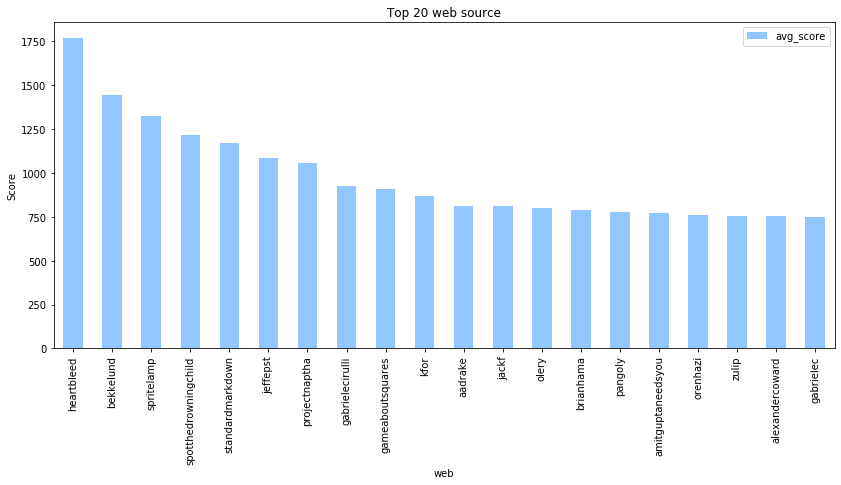

In [98]:
web_df2 = web_df2.toPandas()
web_df2.plot(x='web', y='avg_score', 
                    kind="bar",figsize=(14,6),
                    title='Top 20 web source').set_ylabel("Score")

In [42]:
# story score distribution in terms of time
# What is the trend of story score from 2006-2015 in Hacker News?

sqlStatement = """
SELECT AVG(score) as avg_score, 
year(time_ts) as year
FROM story
GROUP BY year
ORDER BY year
"""
story_time_df3 = spark.sql(sqlStatement)

In [43]:
story_time_df3.show()

+------------------+----+
|         avg_score|year|
+------------------+----+
|              6.06|2006|
| 4.946358989929659|2007|
| 6.091248019386709|2008|
| 8.753413717202019|2009|
|10.134668977809355|2010|
| 9.663246523799316|2011|
| 9.841872697860058|2012|
| 12.00671255901592|2013|
|13.979152072544426|2014|
|14.185886438013101|2015|
+------------------+----+



Text(0, 0.5, 'Score')

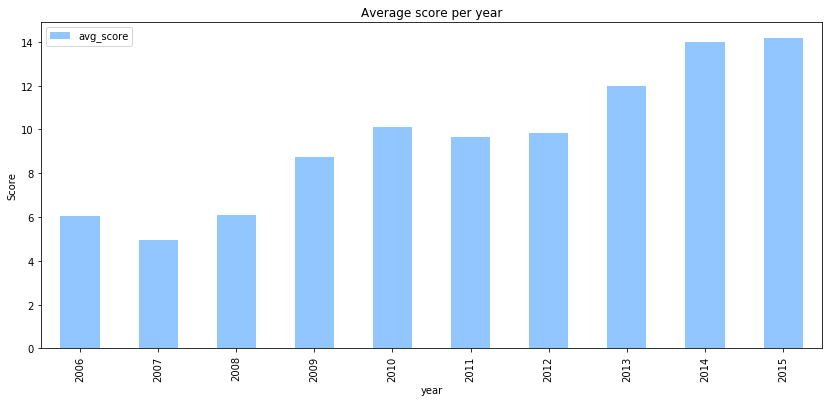

In [44]:
story_time_df3 = story_time_df3.toPandas()
story_time_df3.plot(x='year', y='avg_score', 
                    kind="bar",figsize=(14,6),
                    title='Average score per year', style = 'ggplot').set_ylabel("Score")

In [ ]:
story_time_df3.boxplot(column = [])

In [45]:
# story score distribution in terms of time
# What is the trend of story score in terms of month in Hacker News?

sqlStatement = """
SELECT avg(score) AS avg_score, 
month(time_ts) as month
FROM story
GROUP BY month
ORDER BY month
"""
story_time_df4 = spark.sql(sqlStatement)

In [46]:
story_time_df4.show()

+------------------+-----+
|         avg_score|month|
+------------------+-----+
| 11.23613530112751|    1|
|11.063018489187197|    2|
|11.020218386268116|    3|
|11.052558782849239|    4|
|10.790274943998174|    5|
|11.403842012638394|    6|
|11.134505450913444|    7|
|11.368419560394383|    8|
|10.850541924144569|    9|
|10.772186897244652|   10|
| 10.66730210821811|   11|
|11.322666440073077|   12|
+------------------+-----+



Text(0, 0.5, 'Score')

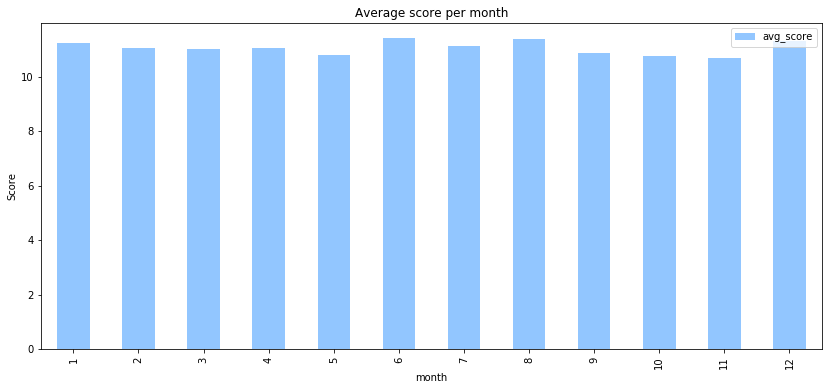

In [47]:
story_time_df4 = story_time_df4.toPandas()
story_time_df4.plot(x='month', y='avg_score', 
                    kind="bar",figsize=(14,6),
                    title='Average score per month', style = 'ggplot').set_ylabel("Score")

In [48]:
# story score distribution in terms of time
# What is the trend of story score in terms of day of week in Hacker News?
story_weekday = clean_story_df2.withColumn('dayofweek', dayofweek('time_ts'))
story_weekday.createOrReplaceTempView('story_weekday')
sqlStatement = """
SELECT avg(score) AS avg_score, 
dayofweek
FROM story_weekday
GROUP BY dayofweek
ORDER BY dayofweek
"""
story_time_df5 = spark.sql(sqlStatement)

In [49]:
story_time_df5.show()

+------------------+---------+
|         avg_score|dayofweek|
+------------------+---------+
|13.618297592260948|        1|
| 11.24427914764196|        2|
|10.573245782543397|        3|
|10.552256279267773|        4|
|10.650321277700893|        5|
|10.629711939810008|        6|
|11.861093349235201|        7|
+------------------+---------+



Text(0, 0.5, 'Score')

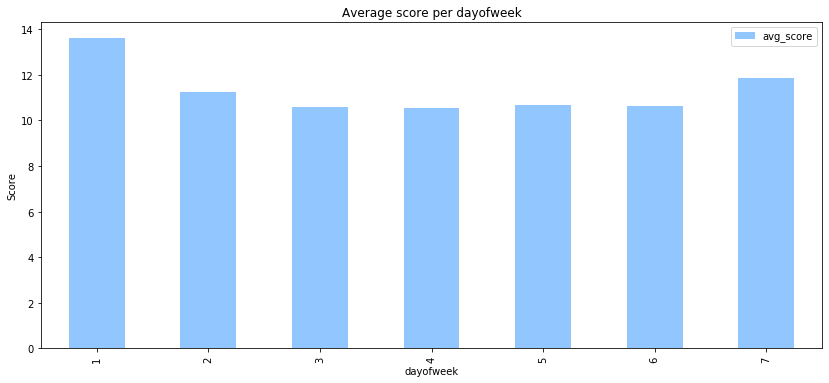

In [50]:
story_time_df5 = story_time_df5.toPandas()
story_time_df5.plot(x='dayofweek', y='avg_score', 
                    kind="bar",figsize=(14,6),
                    title='Average score per dayofweek', style = 'ggplot').set_ylabel("Score")

In [51]:
# story score distribution in terms of time
# What is the trend of story score in terms of hours in Hacker News?

sqlStatement = """
SELECT avg(score) AS avg_score, 
hour(time_ts) as hour
FROM story
GROUP BY hour
ORDER BY hour
"""
story_time_df6 = spark.sql(sqlStatement)

In [52]:
story_time_df6.show()

+------------------+----+
|         avg_score|hour|
+------------------+----+
|11.598216358430705|   0|
| 11.28815007731749|   1|
| 10.93872130525517|   2|
|10.584368642050128|   3|
|10.080007025863962|   4|
| 9.611467220724107|   5|
| 8.720997352545462|   6|
| 9.006834968581193|   7|
| 8.915518104818517|   8|
| 9.255669333775549|   9|
| 9.840166489051535|  10|
|10.747760798516031|  11|
| 11.27910741632028|  12|
|11.690123869304756|  13|
|11.698577855923876|  14|
|11.244159431347363|  15|
|11.591558143241546|  16|
|12.195445288262054|  17|
|11.919092229848204|  18|
|12.021098621234742|  19|
+------------------+----+
only showing top 20 rows



Text(0, 0.5, 'Score')

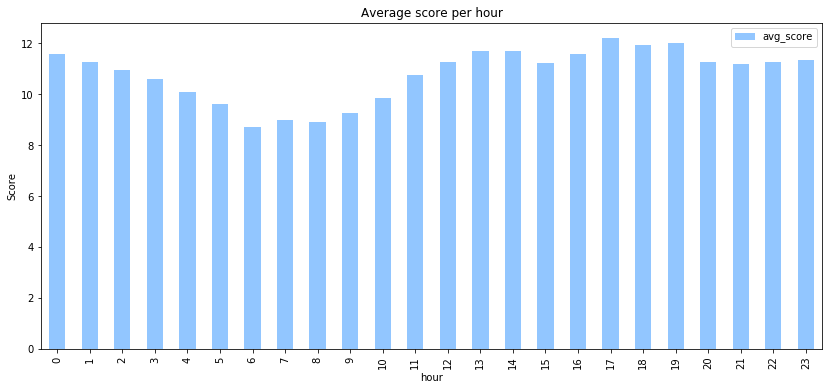

In [53]:
story_time_df6 = story_time_df6.toPandas()
story_time_df6.plot(x='hour', y='avg_score', 
                    kind="bar",figsize=(14,6),
                    title='Average score per hour', style = 'ggplot').set_ylabel("Score")

In [76]:
# story score distribution in terms of time
# What is the trend of story score from 2006-2015 in Hacker News?

sqlStatement = """
SELECT COUNT(id) AS story_num, 
month(time_ts) as month
FROM story
GROUP BY month
ORDER BY month
"""
story_time_df7 = spark.sql(sqlStatement)

In [73]:
story_time_df7.show()

+---------+-----+
|story_num|month|
+---------+-----+
|   130908|    1|
|   127534|    2|
|   144423|    3|
|   139539|    4|
|   140174|    5|
|   134669|    6|
|   141169|    7|
|   141081|    8|
|   143378|    9|
|   136353|   10|
|   124323|   11|
|   117685|   12|
+---------+-----+



In [ ]:
story_time_df7 = story_time_df7.toPandas()
story_time_df7.plot(x='month', y='story_num', 
                    kind="bar",figsize=(14,6),
                    title='Stories per month', style = 'ggplot').set_ylabel("Score")

In [99]:
# story number distribution in terms of time
# What is the trend of story numbers from 2006-2015 in Hacker News?

sqlStatement = """
SELECT COUNT(id) AS story_num, 
year(time_ts) as year
FROM story
GROUP BY year
ORDER BY year
"""
story_time_df1 = spark.sql(sqlStatement)

In [100]:
story_time_df1.show()

+---------+----+
|story_num|year|
+---------+----+
|       50|2006|
|    19761|2007|
|    64374|2008|
|   102674|2009|
|   163267|2010|
|   270554|2011|
|   292391|2012|
|   280221|2013|
|   232685|2014|
|   195259|2015|
+---------+----+



Text(0, 0.5, 'Number')

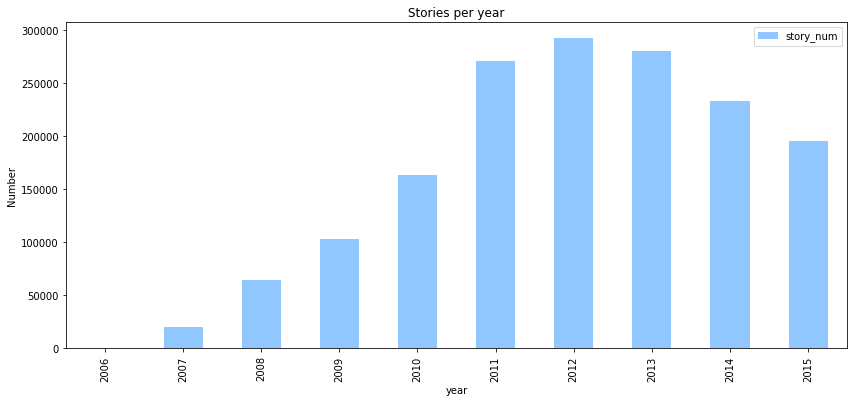

In [101]:
story_time_df1 = story_time_df1.toPandas()
story_time_df1.plot(x='year', y='story_num', 
                    kind="bar",figsize=(14,6),
                    title='Stories per year', style = 'ggplot').set_ylabel("Number")

In [102]:
# story number distribution in terms of time
# What is the most popular/active time during a day in pubulishing a story?

sqlStatement = """
SELECT COUNT(id) AS story_num, 
hour(time_ts) as hour
FROM story
GROUP BY hour
ORDER BY hour
"""
story_time_df2 = spark.sql(sqlStatement)

In [103]:
story_time_df2.show(24)

+---------+----+
|story_num|hour|
+---------+----+
|    51692|   0|
|    49148|   1|
|    47439|   2|
|    46202|   3|
|    45546|   4|
|    45242|   5|
|    46082|   6|
|    45355|   7|
|    45927|   8|
|    48242|   9|
|    49733|  10|
|    56605|  11|
|    68565|  12|
|    83798|  13|
|    96685|  14|
|   103543|  15|
|   106659|  16|
|   105078|  17|
|    99805|  18|
|    91096|  19|
|    85227|  20|
|    78505|  21|
|    67326|  22|
|    57736|  23|
+---------+----+



Text(0, 0.5, 'Number')

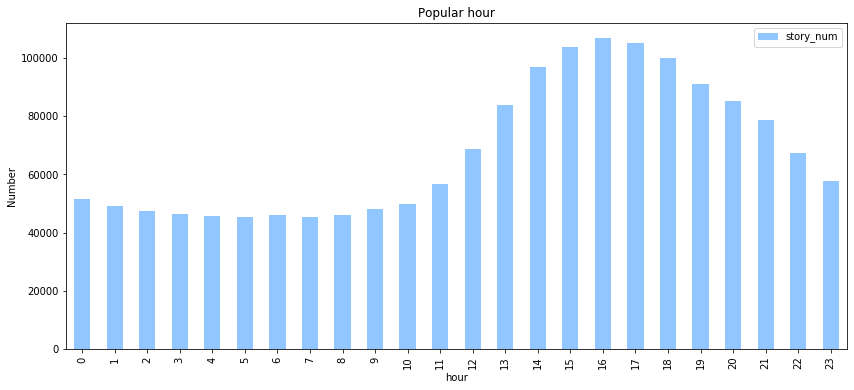

In [104]:
story_time_df2 = story_time_df2.toPandas()
story_time_df2.plot(x='hour', y='story_num', 
                    kind="bar",figsize=(14,6),
                    title='Popular hour').set_ylabel("Number")

In [105]:
# score information
# what is the average score of those story?
spark.sql("select min(score),max(score),avg(score) from story").collect()

[Row(min(score)=0, max(score)=4339, avg(score)=11.055065394550825)]

In [106]:
# author/user information 
# decending by total_score 
sqlStatement = """SELECT SUM(score) as total_score,author,
SUM(descendants) as total_decendants,
count(id) as total_stories
FROM story
GROUP BY author
ORDER BY total_score DESC
LIMIT 20
"""
user_df = spark.sql(sqlStatement)
#user_df.createOrReplaceTempView("user")

In [107]:
user_df.show(10)

+-----------+-----------+----------------+-------------+
|total_score|     author|total_decendants|total_stories|
+-----------+-----------+----------------+-------------+
|      75417|ColinWright|           29929|         3615|
|      63780| shawndumas|           25448|         6533|
|      59469|    llambda|           20136|         2580|
|      56597|      fogus|           21058|         2406|
|      53341|      danso|           22784|         2592|
|      52689|       cwan|           24061|         7058|
|      51709|        luu|           19692|         2248|
|      48935|  ssclafani|           24024|         1318|
|      41234|      evo_9|           15970|         5540|
|      41061| Libertatea|           18950|         2232|
+-----------+-----------+----------------+-------------+
only showing top 10 rows



Text(0, 0.5, 'Score')

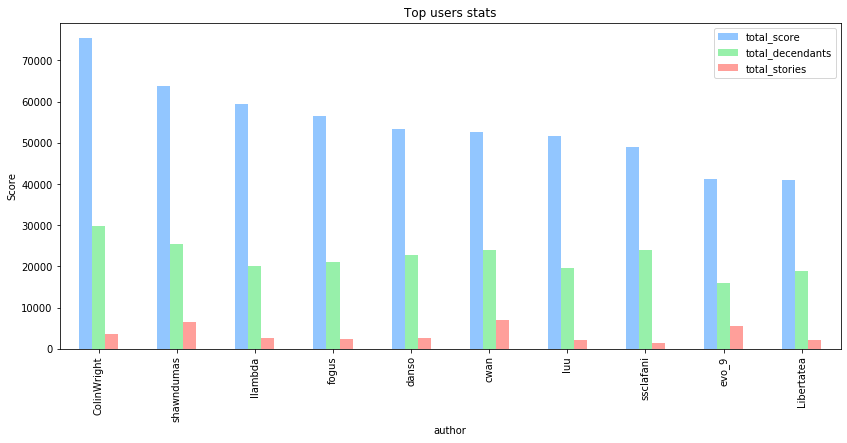

In [108]:
user_df = user_df.toPandas()
user_df.sort_values("total_score")[::-1][:10].plot(x="author",y=["total_score", "total_decendants", "total_stories"], 
                                                   kind="bar",figsize=(14,6),
                                                   title='Top users stats').set_ylabel("Score")

In [109]:
# author/user information 
# decending by total_stories 
sqlStatement = """SELECT SUM(score) as total_score, author,
SUM(descendants) as total_decendants,
count(id) as total_stories
FROM story
GROUP BY author
ORDER BY total_stories DESC
LIMIT 20
"""
user_df2 = spark.sql(sqlStatement)

In [110]:
user_df2.show(10)

+-----------+-----------+----------------+-------------+
|total_score|     author|total_decendants|total_stories|
+-----------+-----------+----------------+-------------+
|      52689|       cwan|           24061|         7058|
|      63780| shawndumas|           25448|         6533|
|      41234|      evo_9|           15970|         5540|
|      29450|      nickb|           11776|         4300|
|      26431|   iProject|           11759|         4262|
|      28334|   bootload|           11272|         4132|
|      29501|     edw519|           13577|         3809|
|      29733|     nreece|           12516|         3682|
|      75417|ColinWright|           29929|         3615|
|      36203| tokenadult|           19890|         3588|
+-----------+-----------+----------------+-------------+
only showing top 10 rows



/home/hadoop/miniconda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


Text(0, 0.5, 'Stories')

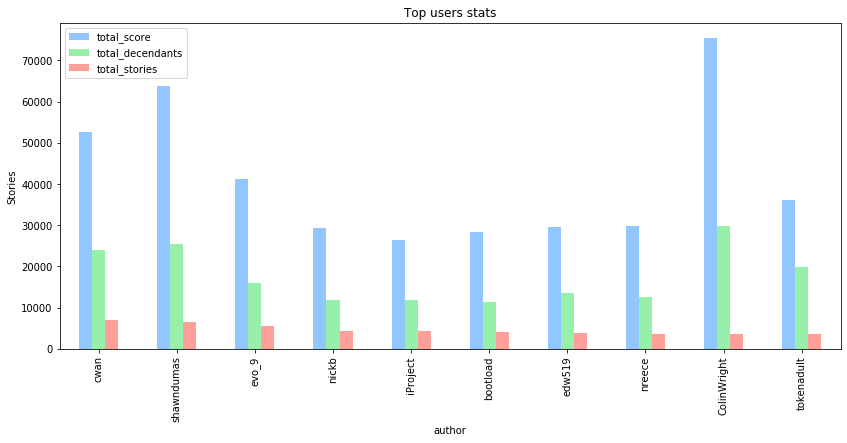

In [111]:
user_df2 = user_df2.toPandas()
user_df2.sort_values("total_stories")[::-1][:10].plot(x="author",y=["total_score", "total_decendants", "total_stories"], 
                                                   kind="bar",figsize=(14,6),
                                                   title='Top users stats').set_ylabel("Stories")

In [112]:
# author/user information 
# decending by avg_score 
sqlStatement = """SELECT SUM(score) as total_score, author,
SUM(descendants) as total_decendants, SUM(score)/count(id) as avg_score,
count(id) as total_stories
FROM story
GROUP BY author
ORDER BY avg_score DESC
LIMIT 20
"""
user_df3 = spark.sql(sqlStatement)

In [113]:
user_df3.show(10)

+-----------+---------------+----------------+---------+-------------+
|total_score|         author|total_decendants|avg_score|total_stories|
+-----------+---------------+----------------+---------+-------------+
|       1543|    realfuncode|             526|   1543.0|            1|
|       2905|     frederfred|             412|   1452.5|            2|
|       1282|          rcina|             249|   1282.0|            1|
|       1257|         kvargs|             558|   1257.0|            1|
|       1248|        mmebane|             267|   1248.0|            1|
|       1227|FlemishBeeCycle|             444|   1227.0|            1|
|       1172|     hannahmitt|             136|   1172.0|            1|
|       1125|  afraidofadria|             985|   1125.0|            1|
|       4354|   patricktomas|             385|   1088.5|            4|
|       1032|       ikeellis|             542|   1032.0|            1|
+-----------+---------------+----------------+---------+-------------+
only s

/home/hadoop/miniconda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


Text(0, 0.5, 'Score')

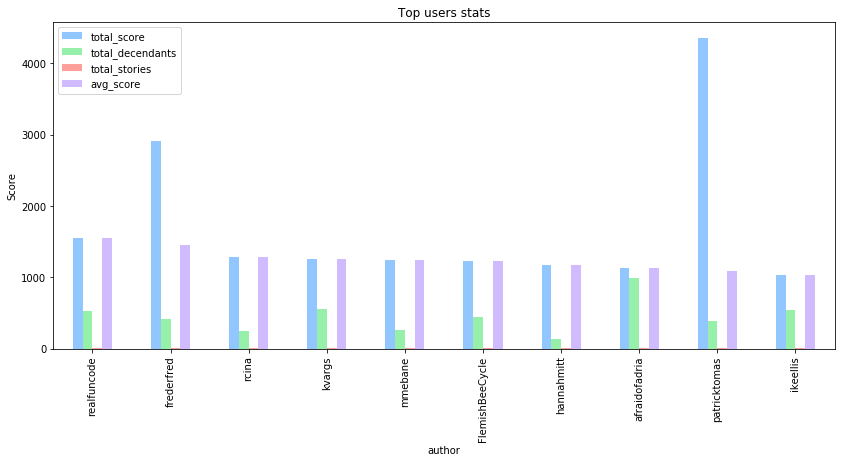

In [114]:
user_df3 = user_df3.toPandas()
user_df3.sort_values("avg_score")[::-1][:10].plot(x="author",y=["total_score", "total_decendants", "total_stories", 'avg_score'], 
                                                   kind="bar",figsize=(14,6),
                                                   title='Top users stats').set_ylabel("Score")

In [115]:
# if there is bias on YC
sqlStatement = """
SELECT score, title,id
FROM `story`
WHERE title like "%Y Combinator%" or title like "%YCombinator%" or title like "%ycombinator%" or title like "%y combinator%"
ORDER BY score  DESC
"""
YC_df = spark.sql(sqlStatement)

In [116]:
YC_df.distinct().show()
YC_df.distinct().count()

+-----+--------------------+-------+
|score|               title|     id|
+-----+--------------------+-------+
| 1065|Y Combinator is f...|5059806|
|  841|Y Combinator has ...|8033322|
|  705|Meet Watsi, Y Com...|5117385|
|  687|New: Apply to Y C...|3700712|
|  589|How I Got Kicked ...|2208155|
|  550|Benefits matter, ...|5409273|
|  549|What Happens At Y...|1733236|
|  542|How Y Combinator ...|3711008|
|  506|Y Combinator Numbers|2608440|
|  432|New Y Combinator ...|7972138|
|  425|Yuri Milner, SV A...|2154706|
|  380|Y Combinator And ...|8178450|
|  379|How I Crashed and...|8867335|
|  368|Early Photos of Y...|2942958|
|  366|Investment Firm Y...|3492711|
|  344|Y Combinator anno...|1898432|
|  342|Offer HN now at n...|1840060|
|  334|Startup developin...|7108684|
|  310|TempleOS is apply...|9246855|
|  310|Applications open...|3515307|
+-----+--------------------+-------+
only showing top 20 rows



2499

/home/hadoop/miniconda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


Text(0, 0.5, 'Score')

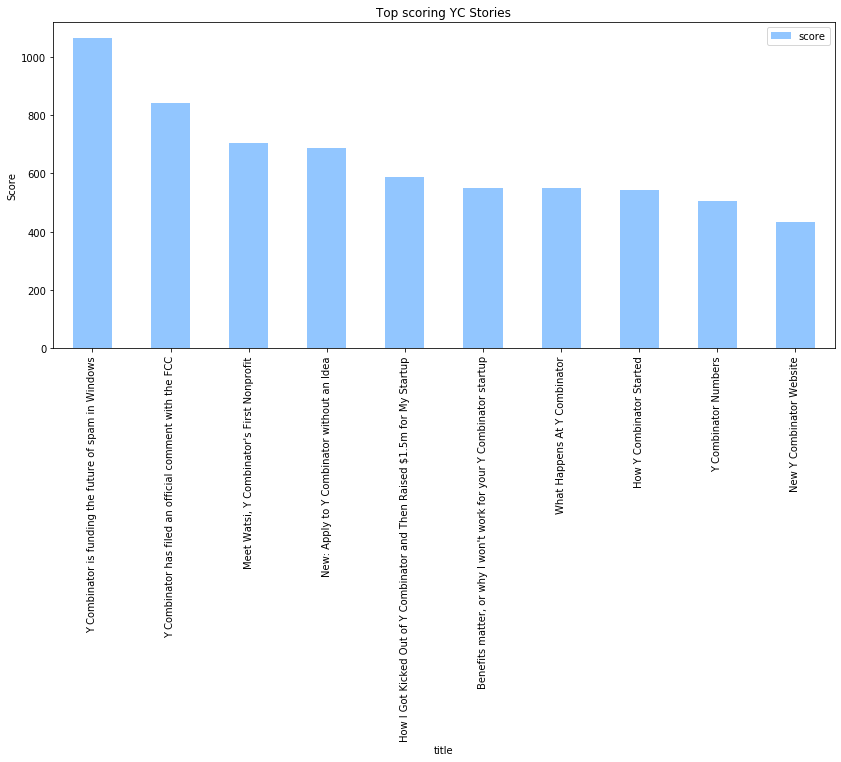

In [117]:
YC_df = YC_df.distinct().toPandas()
YC_df.sort_values("score")[::-1][:10].plot(x="title",y=["score"], 
                                                   kind="bar",figsize=(14,6),
                                                   title='Top scoring YC Stories').set_ylabel("Score")

In [118]:
# stories of major companies over the year
# apple
sqlStatement = """
SELECT count(*) as total_stories, SUM(score) as total_score,
year(time_ts) as year
FROM story
WHERE title like "%apple%" or title like "%APPLE" or title like "%Apple"
GROUP BY year
ORDER BY year
"""
Comp_df1 = spark.sql(sqlStatement)

In [119]:
Comp_df1.distinct().show()

+-------------+-----------+----+
|total_stories|total_score|year|
+-------------+-----------+----+
|            1|          7|2006|
|           27|        105|2007|
|           42|        323|2008|
|           84|        774|2009|
|          187|       1946|2010|
|          340|       5223|2011|
|          373|       4861|2012|
|          258|       2301|2013|
|          154|       2237|2014|
|          134|       3611|2015|
+-------------+-----------+----+



/home/hadoop/miniconda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


Text(0, 0.5, 'Stories')

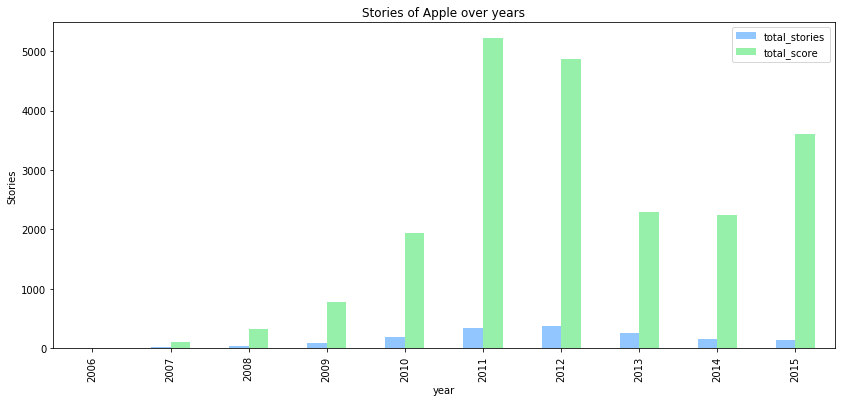

In [120]:
Comp_df1 = Comp_df1.toPandas()
Comp_df1.plot(x="year",y=["total_stories", 'total_score'], 
              kind="bar",figsize=(14,6),
              title='Stories of Apple over years').set_ylabel("Stories")

In [121]:
# stories of major companies over the year
# google
sqlStatement = """
SELECT count(*) as total_stories, SUM(score) as total_score,
year(time_ts) as year
FROM story
WHERE title like "%google%" or title like "%GOOGLE" or title like "%Google"
GROUP BY year
ORDER BY year
"""
Comp_df2 = spark.sql(sqlStatement)

In [122]:
Comp_df2.distinct().show()

+-------------+-----------+----+
|total_stories|total_score|year|
+-------------+-----------+----+
|            1|          1|2006|
|           99|        490|2007|
|          179|       1155|2008|
|          415|       3275|2009|
|          521|       6786|2010|
|          491|       8873|2011|
|          455|       7188|2012|
|          454|      10730|2013|
|          365|       7734|2014|
|          303|       9052|2015|
+-------------+-----------+----+



Text(0, 0.5, 'Stories')

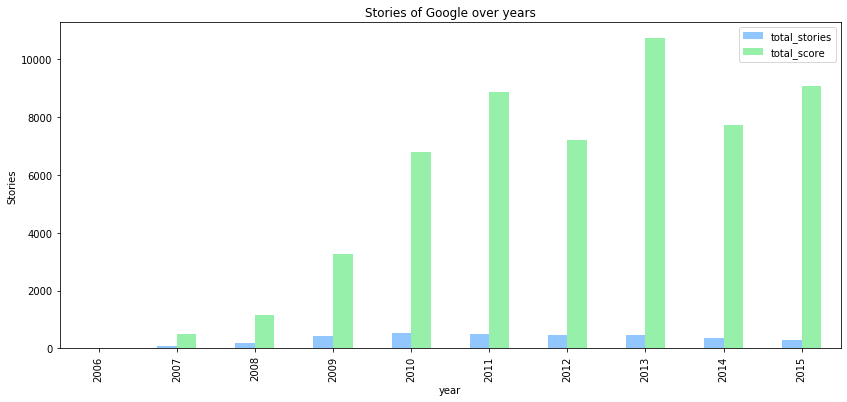

In [123]:
Comp_df2 = Comp_df2.toPandas()
Comp_df2.plot(x="year",y=["total_stories", 'total_score'], 
              kind="bar",figsize=(14,6),
              title='Stories of Google over years').set_ylabel("Stories")

In [124]:
# stories of major companies over the year
# uber
sqlStatement = """
SELECT count(*) as total_stories, SUM(score) as total_score,
year(time_ts) as year
FROM story
WHERE title like "%uber%" or title like "%UBER" or title like "%Uber"
GROUP BY year
ORDER BY year
"""
Comp_df3 = spark.sql(sqlStatement)

In [125]:
Comp_df3.distinct().show()

+-------------+-----------+----+
|total_stories|total_score|year|
+-------------+-----------+----+
|            3|          3|2007|
|           21|        196|2008|
|           22|        953|2009|
|           58|       1109|2010|
|           66|        957|2011|
|           57|        873|2012|
|           62|        518|2013|
|          215|       2697|2014|
|          267|       3240|2015|
+-------------+-----------+----+



Text(0, 0.5, 'Stories')

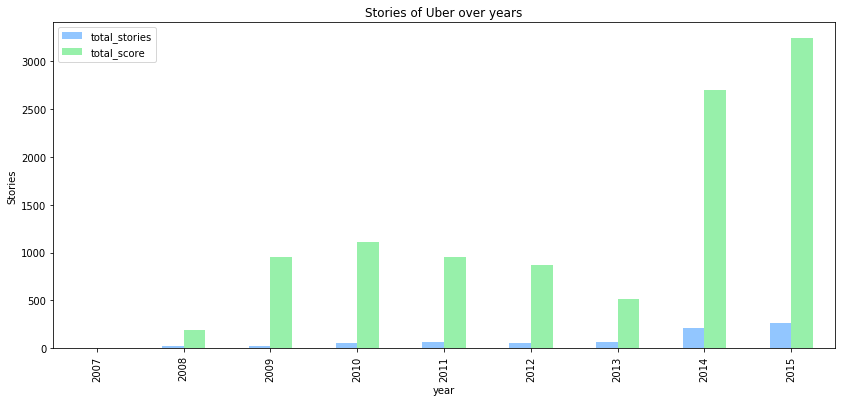

In [126]:
Comp_df3 = Comp_df3.toPandas()
Comp_df3.plot(x="year",y=["total_stories", 'total_score'], 
              kind="bar",figsize=(14,6),
              title='Stories of Uber over years').set_ylabel("Stories")

# 2. COMMENTS

In [22]:
# read in the dataset comments
data_df2 = spark.read\
  .format('csv')\
  .option('header', 'true')\
  .option('inferSchema', 'true')\
  .load('s3://chingsez/Final/comments.csv')

In [23]:
data_df2.show()

+--------------------+-------+------+----------+--------------------+--------------------+--------------------+--------------------+-------+-------+
|                  id|     by|author|      time|             time_ts|                text|              parent|             deleted|   dead|ranking|
+--------------------+-------+------+----------+--------------------+--------------------+--------------------+--------------------+-------+-------+
|             2701393|     5l|    5l|1309184881|2011-06-27 14:28:...|And the glazier w...|             2701243|                null|   null|      0|
|             5811403|     99|    99|1370234048|2013-06-03 04:34:...|Does canada have ...|             5804452|                null|   null|      0|
|               21623|     AF|    AF|1178992400|2007-05-12 17:53:...|"Speaking of Rail...|               21611|                null|   null|      0|
|            10159727|     EA|    EA|1441206574|2015-09-02 15:09:...|Humans and large ...|            1015

In [24]:
data_df2.printSchema()

root
 |-- id: string (nullable = true)
 |-- by: string (nullable = true)
 |-- author: string (nullable = true)
 |-- time: string (nullable = true)
 |-- time_ts: string (nullable = true)
 |-- text: string (nullable = true)
 |-- parent: string (nullable = true)
 |-- deleted: string (nullable = true)
 |-- dead: string (nullable = true)
 |-- ranking: string (nullable = true)



In [25]:
data_df2.count()

9796725

In [26]:
data_df2.select("author").distinct().count()

507804

In [27]:
#Set data type
comment_df = data_df2.select(
                     data_df2['id'].cast(IntegerType()),                    
                     data_df2['time_ts'].cast('timestamp'),                  
                     data_df2['text'],
                     data_df2['parent'].cast(IntegerType()),
                     #data_df2['deleted'],
                     #data_df2['dead'],
                     data_df2['author'],
                     data_df2['ranking'].cast(IntegerType())

                             )
comment_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- time_ts: timestamp (nullable = true)
 |-- text: string (nullable = true)
 |-- parent: integer (nullable = true)
 |-- author: string (nullable = true)
 |-- ranking: integer (nullable = true)



In [28]:
comment_df.show(10)

+--------+-------------------+--------------------+--------+------+-------+
|      id|            time_ts|                text|  parent|author|ranking|
+--------+-------------------+--------------------+--------+------+-------+
| 2701393|2011-06-27 14:28:01|And the glazier w...| 2701243|    5l|      0|
| 5811403|2013-06-03 04:34:08|Does canada have ...| 5804452|    99|      0|
|   21623|2007-05-12 17:53:20|"Speaking of Rail...|   21611|    AF|      0|
|10159727|2015-09-02 15:09:34|Humans and large ...|10159396|    EA|      0|
| 2988424|2011-09-12 18:53:00|I must say I reac...| 2988179|    Iv|      0|
| 3867418|2012-04-20 11:39:44|&#62; There's a w...| 3867404|    Iv|      0|
| 3925617|2012-05-03 20:26:05|I'm also in this ...| 3924840|    Iv|      0|
| 3107534|2011-10-13 15:34:04|how do you run un...|    null|    Iv|   null|
|    null|               null|                null|    null|  null|   null|
| 8409259|2014-10-04 11:20:47|Polio is not exte...| 8409226|    Iv|      0|
+--------+--

In [29]:
comment_df.createOrReplaceTempView('ini_comment')
comment_df.select("id").distinct().count()

8399564

In [30]:
#Get clean comments dataset
clean_comment_df = spark.sql('select * from ini_comment where id is not NULL and time_ts is not NULL and text is not NULL and author is not NULL and ranking is not NULL')
clean_comment_df.createOrReplaceTempView('comment')

In [135]:
#count and show top 10 of the dataset
print(clean_comment_df.count())
clean_comment_df.show(10)

6986995
+--------+-------------------+--------------------+--------+------+-------+
|      id|            time_ts|                text|  parent|author|ranking|
+--------+-------------------+--------------------+--------+------+-------+
| 2701393|2011-06-27 14:28:01|And the glazier w...| 2701243|    5l|      0|
| 5811403|2013-06-03 04:34:08|Does canada have ...| 5804452|    99|      0|
|   21623|2007-05-12 17:53:20|"Speaking of Rail...|   21611|    AF|      0|
|10159727|2015-09-02 15:09:34|Humans and large ...|10159396|    EA|      0|
| 2988424|2011-09-12 18:53:00|I must say I reac...| 2988179|    Iv|      0|
| 3867418|2012-04-20 11:39:44|&#62; There's a w...| 3867404|    Iv|      0|
| 3925617|2012-05-03 20:26:05|I'm also in this ...| 3924840|    Iv|      0|
| 8409259|2014-10-04 11:20:47|Polio is not exte...| 8409226|    Iv|      0|
|   50570|2007-09-05 17:04:05|It was a risky jo...|   50556|    Jd|      0|
| 2600618|2011-05-30 22:34:14|"Looks good, ther...| 2600609|    Jd|      0|
+---

In [136]:
# comment author/user information 
# who are the most contributive authors in Hacker News ?
## futhur to be done——can be joined with the most contirbutive authors in story

sqlStatement = """SELECT author,
        COUNT(id) AS total_comments
        From comment
        GROUP BY author
        ORDER BY total_comments DESC
        LIMIT 20
"""
comment_user_df = spark.sql(sqlStatement)

In [137]:
# show top 10
comment_user_df.show(10)

+------------+--------------+
|      author|total_comments|
+------------+--------------+
|     tptacek|         28605|
|    jacquesm|         19845|
|       DanBC|         10992|
|    jrockway|         10679|
|   anigbrowl|         10490|
|dragonwriter|         10203|
|         eru|          9979|
|     rbanffy|          9634|
|       sp332|          9547|
|     rayiner|          9403|
+------------+--------------+
only showing top 10 rows



Text(0, 0.5, 'Comments')

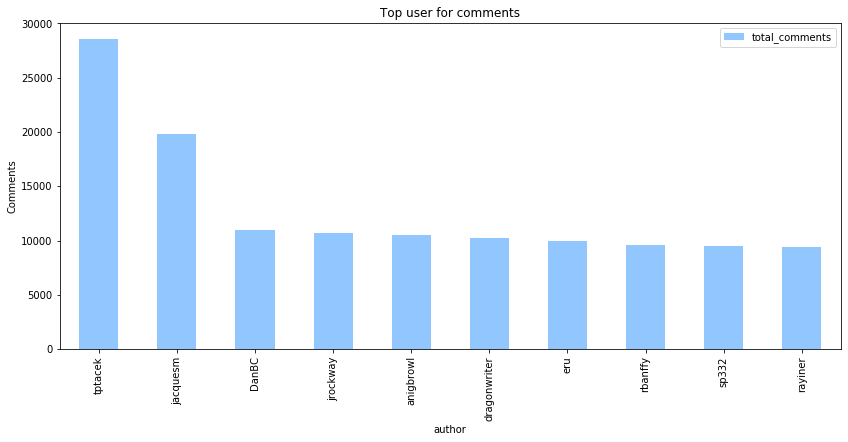

In [138]:
comment_user_df = comment_user_df.toPandas()
comment_user_df.sort_values("total_comments")[::-1][:10].plot(x="author",y='total_comments', 
                                                   kind="bar",figsize=(14,6),
                                                   title='Top user for comments').set_ylabel("Comments")

In [59]:

# get the top 100 users according to the comment numbers and create temp view comment_user_forjoin
sqlStatement = """SELECT author,
        COUNT(id) AS total_comments
        From comment
        GROUP BY author
        ORDER BY total_comments DESC
        LIMIT 1000
"""
comment_user_df_forjoin = spark.sql(sqlStatement)
comment_user_df_forjoin.createOrReplaceTempView('comment_user_forjoin')

In [60]:
# to be deleted because didn't use number 
# get the top users according to the story numbers and create temp view comment_user_forjoin
# decending by total_stories get top story users
sqlStatement = """SELECT  author,
count(id) as total_stories
FROM story
GROUP BY author
ORDER BY total_stories DESC
LIMIT 1000
"""
story_user_df_forjoin = spark.sql(sqlStatement)
story_user_df_forjoin.createOrReplaceTempView('story_user_forjoin')

In [61]:
# get the top  users according to the story score and create temp view comment_user_forjoin
# decending by total_score get top story users
sqlStatement = """SELECT SUM(score) as total_score,author
FROM story
GROUP BY author
ORDER BY total_score DESC
LIMIT 1000
"""
story_user_df_forjoin2 = spark.sql(sqlStatement)
story_user_df_forjoin2.createOrReplaceTempView('story_user_forjoin2')

In [42]:
#story_user_df_forjoin2.show()

+-----------+--------------+
|total_score|        author|
+-----------+--------------+
|      75417|   ColinWright|
|      63780|    shawndumas|
|      59469|       llambda|
|      56597|         fogus|
|      53341|         danso|
|      52689|          cwan|
|      51709|           luu|
|      48935|     ssclafani|
|      41234|         evo_9|
|      41061|    Libertatea|
|      40028| DanielRibeiro|
|      38399|          lelf|
|      36827|      jgrahamc|
|      36203|    tokenadult|
|      34872|            pg|
|      34493|       Garbage|
|      33605|          wglb|
|      33223|        uptown|
|      31758|aaronbrethorst|
|      29733|        nreece|
+-----------+--------------+
only showing top 20 rows



In [62]:
# get the top users according to the story score and create temp view comment_user_forjoin
# decending by total_score get top story users
sqlStatement = """SELECT avg(score) as avg_score,author
FROM story
GROUP BY author
ORDER BY avg_score DESC
LIMIT 1000
"""
story_user_df_forjoin3 = spark.sql(sqlStatement)
story_user_df_forjoin3.createOrReplaceTempView('story_user_forjoin3')

In [40]:
story_user_df_forjoin3.show()

+---------+---------------+
|avg_score|         author|
+---------+---------------+
|   1543.0|    realfuncode|
|   1452.5|     frederfred|
|   1282.0|          rcina|
|   1257.0|         kvargs|
|   1248.0|        mmebane|
|   1227.0|FlemishBeeCycle|
|   1172.0|     hannahmitt|
|   1125.0|  afraidofadria|
|   1088.5|   patricktomas|
|   1032.0|       ikeellis|
|   1014.0|    bigfishprod|
|    988.0|       rockybox|
|    986.5|        knurdle|
|    965.0|  jonathanporta|
|    944.0|          frans|
|    942.0|        spiznnx|
|    907.0|         Kajdav|
|    906.0|       sqnguyen|
|    883.0|         chummm|
|    807.5|        alloyed|
+---------+---------------+
only showing top 20 rows



In [63]:
# join 
# join the two table  
sqlStatement = """SELECT s.author,s.total_score,c.author,c.avg_score
From story_user_forjoin2 s, story_user_forjoin3 c
WHERE s.author = c.author
ORDER By s.total_score DESC
"""
cross_user_ta_df = spark.sql(sqlStatement)
cross_user_ta_df.count()

16

In [64]:
cross_user_ta_df.show()

+--------------+-----------+--------------+------------------+
|        author|total_score|        author|         avg_score|
+--------------+-----------+--------------+------------------+
|          sama|       9353|          sama|148.46031746031747|
|       anateus|       6101|       anateus|174.31428571428572|
|     gkoberger|       4940|     gkoberger|182.96296296296296|
|       ibdknox|       4892|       ibdknox|203.83333333333334|
|  patricktomas|       4354|  patricktomas|            1088.5|
|           gdb|       4299|           gdb|204.71428571428572|
|       ericflo|       4185|       ericflo|160.96153846153845|
|      tomlemon|       3696|      tomlemon|194.52631578947367|
|         rohin|       3434|         rohin|163.52380952380952|
|  chimeracoder|       3420|  chimeracoder|             380.0|
|          df07|       3109|          df07|222.07142857142858|
|    frederfred|       2905|    frederfred|            1452.5|
|jenniferDewalt|       2698|jenniferDewalt|299.77777777

In [65]:
cross_user_ta_df.createOrReplaceTempView('cross_user_ta')

In [66]:
# join 2
# join the two table 
sqlStatement = """SELECT s.author,s.total_score,c.author,c.total_comments
From story_user_forjoin2 s, comment_user_forjoin c
WHERE s.author = c.author
ORDER By s.total_score DESC
"""
cross_user_tc_df = spark.sql(sqlStatement)
cross_user_tc_df.count()

184

In [67]:
cross_user_tc_df.show()

+--------------+-----------+--------------+--------------+
|        author|total_score|        author|total_comments|
+--------------+-----------+--------------+--------------+
|   ColinWright|      75417|   ColinWright|          3594|
|         danso|      53341|         danso|          2736|
| DanielRibeiro|      40028| DanielRibeiro|          1007|
|      jgrahamc|      36827|      jgrahamc|          2783|
|    tokenadult|      36203|    tokenadult|          4161|
|            pg|      34872|            pg|          8981|
|          wglb|      33605|          wglb|          2630|
|        uptown|      33223|        uptown|          1633|
|aaronbrethorst|      31758|aaronbrethorst|          1899|
|        edw519|      29501|        edw519|          2728|
|    prostoalex|      28869|    prostoalex|          1226|
|      bootload|      28334|      bootload|          1320|
|   robin_reala|      26538|   robin_reala|          1004|
|   adamnemecek|      25490|   adamnemecek|          152

In [68]:
# join 2
# join the two table 
sqlStatement = """SELECT s.author,s.avg_score,c.author,c.total_comments
From story_user_forjoin3 s, comment_user_forjoin c
WHERE s.author = c.author
ORDER By s.avg_score DESC
"""
cross_user_ac_df = spark.sql(sqlStatement)
cross_user_ac_df.count()

4

In [69]:
cross_user_ac_df.show()

+------------+---------+------------+--------------+
|      author|avg_score|      author|total_comments|
+------------+---------+------------+--------------+
|drivebyacct2|    402.0|drivebyacct2|          3691|
|chimeracoder|    380.0|chimeracoder|          2019|
|    Tloewald|    276.5|    Tloewald|          1961|
|     talmand|    194.0|     talmand|          2155|
+------------+---------+------------+--------------+



In [70]:
# join 3

sqlStatement = """SELECT s.author,s.total_score,a.author,a.avg_score,c.author,c.total_comments
From story_user_forjoin2 s, story_user_forjoin3 a,comment_user_forjoin c
WHERE s.author = c.author
AND s.author = a.author
AND a.author = c.author
"""
cross_user_tac_df = spark.sql(sqlStatement)
cross_user_tac_df.count()

1

In [71]:
cross_user_tac_df.show()

+------------+-----------+------------+---------+------------+--------------+
|      author|total_score|      author|avg_score|      author|total_comments|
+------------+-----------+------------+---------+------------+--------------+
|chimeracoder|       3420|chimeracoder|    380.0|chimeracoder|          2019|
+------------+-----------+------------+---------+------------+--------------+



In [143]:
# comment distribution in terms of time
# What is the trend of comment numbers from 2006-2016 in Hacker News?

sqlStatement = """
SELECT COUNT(id) AS comment_num, 
year(time_ts) as year
FROM comment
GROUP BY year
ORDER BY year
"""
comment_time_df2 = spark.sql(sqlStatement)

In [144]:
comment_time_df2.show()

+-----------+----+
|comment_num|year|
+-----------+----+
|         10|2006|
|      50982|2007|
|     195678|2008|
|     382490|2009|
|     658846|2010|
|     816999|2011|
|     975306|2012|
|    1415381|2013|
|    1348324|2014|
|    1142979|2015|
+-----------+----+



/home/hadoop/miniconda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


Text(0, 0.5, 'Comments')

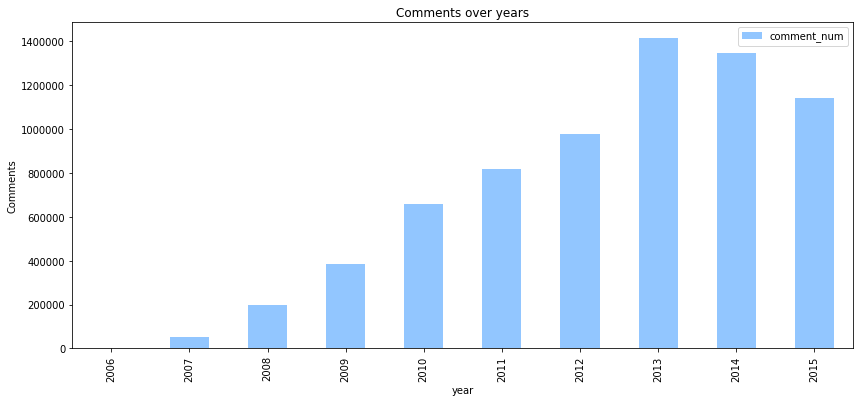

In [145]:
comment_time_df2 = comment_time_df2.toPandas()
comment_time_df2.plot(x="year",y='comment_num', 
                     kind="bar",figsize=(14,6),
                     title='Comments over years').set_ylabel("Comments")

In [146]:
# comment distribution in terms of time
# What is the most popular/active time during a day in pubulishing a comment?

sqlStatement = """
SELECT COUNT(id) AS comment_num, 
hour(time_ts) as hour
FROM comment
GROUP BY hour
ORDER BY hour
"""
comment_time_df = spark.sql(sqlStatement)

In [147]:
comment_time_df.show(24)

+-----------+----+
|comment_num|hour|
+-----------+----+
|     276703|   0|
|     251256|   1|
|     236036|   2|
|     224956|   3|
|     210740|   4|
|     192913|   5|
|     180795|   6|
|     172147|   7|
|     170884|   8|
|     168104|   9|
|     164236|  10|
|     180141|  11|
|     224367|  12|
|     295136|  13|
|     365798|  14|
|     413518|  15|
|     437369|  16|
|     451259|  17|
|     450094|  18|
|     433640|  19|
|     421504|  20|
|     398429|  21|
|     353708|  22|
|     313262|  23|
+-----------+----+



Text(0, 0.5, 'Comments')

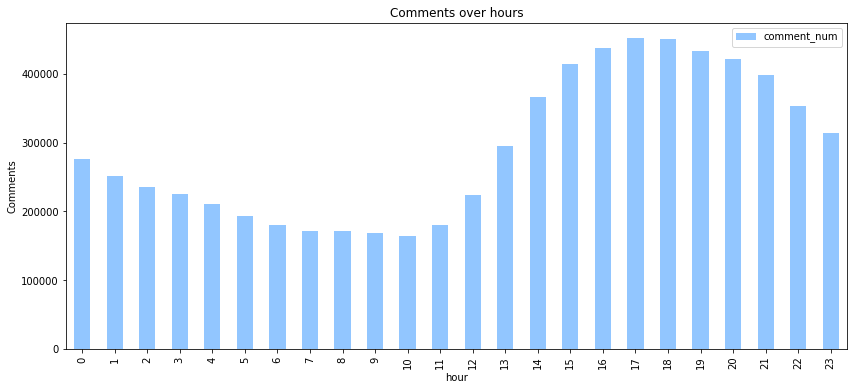

In [148]:
comment_time_df = comment_time_df.toPandas()
comment_time_df.plot(x="hour",y='comment_num', 
                     kind="bar",figsize=(14,6),
                     title='Comments over hours').set_ylabel("Comments")

In [149]:
# top(the hottest) comments with the most follow-up comment 
sqlStatement = """
SELECT COUNT(id) AS followup_num, 
parent
FROM comment
WHERE parent is not NULL
GROUP BY parent
ORDER BY followup_num DESC
LIMIT 20
"""
comment_parent_df1 = spark.sql(sqlStatement)

In [150]:
# show top 10
comment_parent_df1.show(10)

+------------+--------+
|followup_num|  parent|
+------------+--------+
|         975|     363|
|         266| 9996333|
|         266| 7469115|
|         264| 9238839|
|         262| 9812245|
|         243| 7445761|
|         241|10152809|
|         239|  752262|
|         234| 9471287|
|         228| 9303396|
+------------+--------+
only showing top 10 rows



Text(0, 0.5, 'Follow-up')

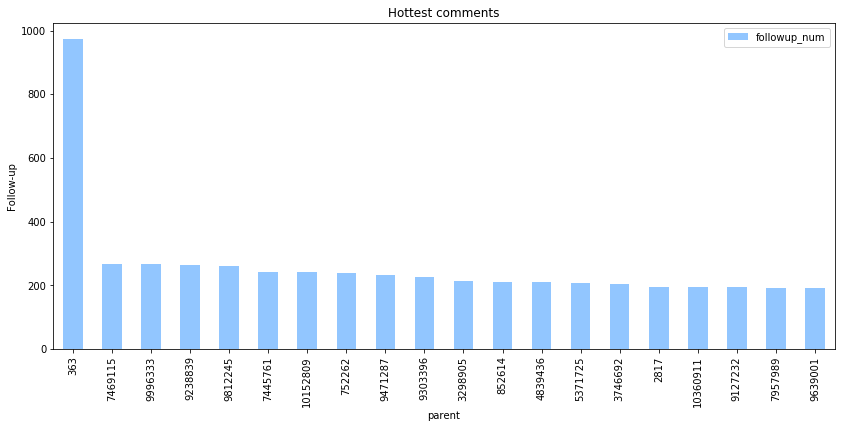

In [151]:
comment_parent_df1 = comment_parent_df1.toPandas()
comment_parent_df1.plot(x="parent",y='followup_num', 
                     kind="bar",figsize=(14,6),
                     title='Hottest comments').set_ylabel("Follow-up")

In [152]:
# ranking information
# what is the average ranking of those comments?

spark.sql("select min(ranking),max(ranking),avg(ranking) from comment").collect()

[Row(min(ranking)=-1051, max(ranking)=1131019295, avg(ranking)=58481.1891668736)]

# Feature Engineering

In [153]:
#Extract the 'day of week', 'year', 'month' information from the 'time_ts' column
story = clean_story_df.withColumn('year', year('time_ts'))
story = story.withColumn('month', month('time_ts'))
story = story.withColumn('dayofweek', dayofweek('time_ts'))

In [154]:
story.show()

+-------+-----+-------------------+--------------------+--------------------+--------------------+-------+----+-----------+------------+----+-----+---------+
|     id|score|            time_ts|               title|                 url|                text|deleted|dead|descendants|      author|year|month|dayofweek|
+-------+-----+-------------------+--------------------+--------------------+--------------------+-------+----+-----------+------------+----+-----+---------+
|1531556|    0|2010-07-20 09:13:54|New UI for Google...|http://googlesyst...|Again following o...|   null|null|          0|         ssn|2010|    7|        3|
|5012398|    0|2013-01-05 12:11:17|Historic website ...|http://webscrapin...|Python script to ...|   null|null|          0|        hoju|2013|    1|        7|
|2606988|    0|2011-06-01 12:36:11|Kidney Transplant...|http://dhshahzad....|I started indepen...|   null|True|          0|       ramis|2011|    6|        4|
|4542754|    0|2012-09-19 08:57:49|Bouncing Marble f

In [155]:
#Add a new column to see whether an author is one of the most active users.
sqlStatement = """
SELECT author, COUNT(author) AS num
FROM story1
GROUP BY author
ORDER BY num DESC
LIMIT 3000
"""
active_user = spark.sql(sqlStatement)
active_user.show()

+-------------+----+
|       author| num|
+-------------+----+
|         cwan|7058|
|   shawndumas|6533|
|        evo_9|5540|
|        nickb|4300|
|     iProject|4262|
|     bootload|4132|
|       edw519|3809|
|       nreece|3682|
|  ColinWright|3615|
|   tokenadult|3588|
|      Garbage|3508|
|         robg|3091|
|DanielRibeiro|2815|
|       Anon84|2741|
|        danso|2592|
|      llambda|2580|
|      jonbaer|2416|
|        fogus|2406|
|   transburgh|2345|
|         wslh|2268|
+-------------+----+
only showing top 20 rows



In [156]:
user = np.array(active_user.select('author').collect())

In [157]:
# Defining a function to map our column 
@udf(StringType())
def is_active_user(username):
    if username in user:
        return '1'
    return '0' 

In [158]:
story = story.withColumn('active_user', is_active_user('author'))

In [159]:
#Add  a variable showing the information about title length
story = story.withColumn('title_length', f.size(f.split(f.col('title'), ' ')))

In [160]:
#Add a variable represents whether an url is from the top domain
sqlStatement = """
SELECT COUNT(id) AS num, web
FROM story
WHERE web != '' and web != 'www'
GROUP BY web
ORDER BY num DESC
LIMIT 50
"""
url_df2 = spark.sql(sqlStatement)

In [161]:
# Defining a function so that we can use to map our column
hot_domain = np.array(url_df2.select('web').collect())
@udf(StringType())
def from_hot_domain(url):
    pattern = re.compile('([a-z]+).(com|net|co|cn|org|ru|de|br|uk|pl|ir|it|in|fr|au|jp|info)')
    result = re.findall(pattern, url)
    if result and result[0] in hot_domain:
        return '1'
    return '0' 

In [162]:
story = story.withColumn('from_top_web', from_hot_domain('url'))

In [163]:
#Extract the length of text information
story = story.withColumn('text_length', f.size(f.split(f.col('text'), ' ')))

In [164]:
# Since there exist empty values in our dataset, we can deal with this data by filling the column with 0
@udf(IntegerType())
def transfer(num):
    if num == -1:
        return 0 
    return num
story = story.withColumn('text_length', transfer('text_length'))

In [165]:
#Add a new column about hot words this title use
# First Let's transform our title 
regexTokenizer = RegexTokenizer(inputCol="title", outputCol="words", pattern="\s+")
regexTokenized = regexTokenizer.transform(story)
regexTokenized.select("title", "words").show()

+--------------------+--------------------+
|               title|               words|
+--------------------+--------------------+
|New UI for Google...|[new, ui, for, go...|
|Historic website ...|[historic, websit...|
|Kidney Transplant...|[kidney, transpla...|
|Bouncing Marble f...|[bouncing, marble...|
|Cooking your own ...|[cooking, your, o...|
|Why You Should Re...|[why, you, should...|
|My developer tool...|[my, developer, t...|
|      Feelspace belt|   [feelspace, belt]|
|      What is Magic?|  [what, is, magic?]|
|Personal Organize...|[personal, organi...|
|Ultimate Guide of...|[ultimate, guide,...|
|       Mens t-shirts|    [mens, t-shirts]|
|  Gümrük Müşavirliği|[gümrük, müşavirl...|
|The Rule of 72: H...|[the, rule, of, 7...|
|Web Design Jobs –...|[web, design, job...|
|The A View from t...|[the, a, view, fr...|
|           Sex toys |         [sex, toys]|
|        Bespoke Suit|     [bespoke, suit]|
|Web 2.0: Browse A...|[web, 2.0:, brows...|
|Dev Vilas Resort ...|[dev, vila

In [166]:
# We don't want these stop words to be in our word list, so we use the StopWordsRemover to filter those stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
filtered = remover.transform(regexTokenized)

In [45]:
# add a word cloud of story title
# first intall wordcloud using the following command
#!pip install wordcloud

     |████████████████████████████████| 368kB 36.9MB/s eta 0:00:01


In [46]:
for_wordcloud = filtered.withColumn('word', f.explode(f.col('filtered')))
for_wordcloud1 = for_wordcloud.select('word').collect()

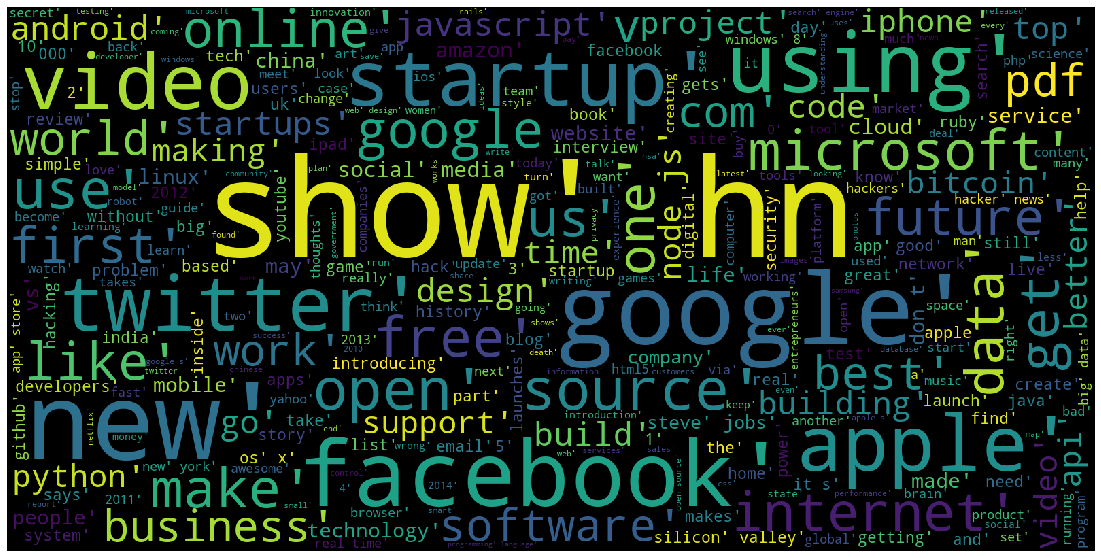

In [48]:
import wordcloud
stopwords = ['Row','word','(',')','=',"'"]
cloud = wordcloud.WordCloud(background_color='black',
                            stopwords=stopwords,
                            max_font_size=200,
                            width=1600,
                            height=800,
                            max_words=300,
                            relative_scaling=.5).generate(str(for_wordcloud1))
plt.figure(figsize=(20,10))
plt.axis('off')
plt.savefig('hackernews.png')
plt.imshow(cloud);

In [167]:
word_count = filtered.withColumn('word', f.explode(f.col('filtered')))\
    .groupBy('word')\
    .count()\
    .sort('count', ascending=False)

In [168]:
# We choose the top 300 words as the hot words
word_list = word_count.limit(300)
hot_words = np.array(word_list.select('word').collect())

In [169]:
# Defining a function to filter those words including numerical characters
def filter_words(array):
    words_list = []
    pattern = re.compile('[a-z]+')
    for word in array:
        result = re.findall(pattern, word[0])
        if result != []:
            words_list.append(result[0])
    return words_list

In [170]:
hot_word = filter_words(hot_words)

In [171]:
# Defining a function so that we can get how many hot words each title includes
@udf(IntegerType())
def count_hot_words(title):
    words = title.split(' ')
    count = 0
    for word in words:
        if word in hot_word:
            count += 1 
    return count 

In [172]:
story = story.withColumn('title_hot_words', count_hot_words('title'))

In [173]:
#transform our title to be a word vector
regexTokenizer = RegexTokenizer(inputCol="title", outputCol="title_array", pattern="\s+")
regexTokenized = regexTokenizer.transform(story)

In [174]:
word2Vec = Word2Vec(vectorSize=300, minCount=5, seed = 18, inputCol="title_array", outputCol="title_vec")
model = word2Vec.fit(regexTokenized)
story_final = model.transform(regexTokenized)

In [175]:
story_final.show(5)

+-------+-----+-------------------+--------------------+--------------------+--------------------+-------+----+-----------+------+----+-----+---------+-----------+------------+------------+-----------+---------------+--------------------+--------------------+
|     id|score|            time_ts|               title|                 url|                text|deleted|dead|descendants|author|year|month|dayofweek|active_user|title_length|from_top_web|text_length|title_hot_words|         title_array|           title_vec|
+-------+-----+-------------------+--------------------+--------------------+--------------------+-------+----+-----------+------+----+-----+---------+-----------+------------+------------+-----------+---------------+--------------------+--------------------+
|1531556|    0|2010-07-20 09:13:54|New UI for Google...|http://googlesyst...|Again following o...|   null|null|          0|   ssn|2010|    7|        3|          0|           6|           1|          5|              0|[ne

In [176]:
data = story_final.select([c for c in story_final.columns if c not in ['id', 'time_ts', 'title', 'url', 'text', 'deleted', 'dead']])

In [177]:
data.select('score').describe().show()

+-------+------------------+
|summary|             score|
+-------+------------------+
|  count|           1621236|
|   mean|11.055065394550825|
| stddev|42.411855877052254|
|    min|                 0|
|    max|              4339|
+-------+------------------+



In [178]:
data.createOrReplaceTempView('story_result')
#Scale score
sqlStatement = """
SELECT *,
CASE
 WHEN (score >11.055065394550825) THEN 1
 WHEN (score <=11.055065394550825) THEN 0
 END as if_highscore
FROM story_result
"""

data = spark.sql(sqlStatement)

In [179]:
data = data.withColumn('score_scaled',(col('score')- 11.055065394550825)/42.41185587705)
data.select('score_scaled').describe().show()

+-------+--------------------+
|summary|        score_scaled|
+-------+--------------------+
|  count|             1621236|
|   mean|-3.29490616853513...|
| stddev|  1.0000000000000526|
|    min| -0.2606597887769624|
|    max|  102.04563901075115|
+-------+--------------------+



In [180]:
#Standardize if_highscore
data.createOrReplaceTempView('story_result_with_if_highscore')
sqlStatement = """
SELECT *,
CASE
 WHEN (score_scaled >-3.295) THEN 1
 WHEN (score_scaled <=-3.295) THEN 0
 END as if_highscore_scaled
FROM story_result_with_if_highscore
"""
data = spark.sql(sqlStatement)

In [181]:
data.select('descendants').describe().show()

+-------+------------------+
|summary|       descendants|
+-------+------------------+
|  count|           1621236|
|   mean| 5.732467697485129|
| stddev|1863.0961498370448|
|    min|                -1|
|    max|           2372103|
+-------+------------------+



In [182]:
#Standardize descendants
data = data.withColumn('des_scaled',(col('descendants')- 5.732467697485129)/1863.096149 )

In [183]:
data.show(5)

+-----+-----------+------+----+-----+---------+-----------+------------+------------+-----------+---------------+--------------------+--------------------+------------+-------------------+-------------------+--------------------+
|score|descendants|author|year|month|dayofweek|active_user|title_length|from_top_web|text_length|title_hot_words|         title_array|           title_vec|if_highscore|       score_scaled|if_highscore_scaled|          des_scaled|
+-----+-----------+------+----+-----+---------+-----------+------------+------------+-----------+---------------+--------------------+--------------------+------------+-------------------+-------------------+--------------------+
|    0|          0|   ssn|2010|    7|        3|          0|           6|           1|          5|              0|[new, ui, for, go...|[0.08796960550049...|           0|-0.2606597887769624|                  1|-0.00307685016715...|
|    0|          0|  hoju|2013|    1|        7|          0|           3|        

In [184]:
data.printSchema()

root
 |-- score: integer (nullable = true)
 |-- descendants: integer (nullable = true)
 |-- author: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- dayofweek: integer (nullable = true)
 |-- active_user: string (nullable = true)
 |-- title_length: integer (nullable = false)
 |-- from_top_web: string (nullable = true)
 |-- text_length: integer (nullable = true)
 |-- title_hot_words: integer (nullable = true)
 |-- title_array: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- title_vec: vector (nullable = true)
 |-- if_highscore: integer (nullable = true)
 |-- score_scaled: double (nullable = true)
 |-- if_highscore_scaled: integer (nullable = true)
 |-- des_scaled: double (nullable = true)



In [188]:
data.write.parquet(path='s3://bigdataproject233/data',mode='overwrite')

In [189]:
spark.stop()